# Instalación y entrega

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

**Cuando termine la práctica, rellenando las celdas de código y respondiendo a las preguntas, descárguelo a su máquina. Para bajar el cuaderno hay que ir a "Archivo --> Descargar --> Descargar .ipynb". Una vez descargado lo tenéis que subir a la actividad en formato ".ipynb".**


In [ ]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

Mounted at /drive
/drive/.shortcut-targets-by-id/1MHsiAeNCqIWHIkKgK7ggxOaSkemKqWSb/data


# Regularización

En esta práctica, con el objetivo de evitar el sobreajuste, incluiremos el **dropout** al modelo usado anteriormente en la base de datos de `Spotify`. Además, veremos cómo la normalización por batches (**batchnorm**) permite el entrenamiento en conjuntos de datos problemáticos. 

En primer lugar configuramos las librerías:

In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Cargamos la base de datos de `Spotify`.

In [ ]:
spotify = pd.read_csv('data_m3/datasets/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(X_train.shape))


Input shape: (24162, 18)


## Dropout

En la práctica anterior tratamos el entrenamiento de una red de dos capas con la base de datos `Spotify`, los resultados del entrenamiento que obtuvimos se pueden ver en la siguiente figura:

<figure style="padding: 1em;"><center>
<img src="https://drive.google.com/uc?id=1tM5CqnT0aMk340DZIaYllTgcLPhruFsq" width=500 alt="">
<figcaption style="textalign: center; font-style: italic"> Curvas de aprendizaje de la práctica anterior.
</center></figcaption>
</figure>

En la siguiente celda, se trata de configurar dos capas de **dropout**, una después de la capa `Dense` con 128 unidades, y otra después de la capa `Dense` con 64 unidades. Establecer la tasa de abandono en ambos a `0.3`.

In [ ]:
# EJERCICIO 1 --------- TO DO
# Añada dos capas de dropout con tasa de eliminación del 30%, una después de una capa 128 elementos
# y otra después de una capa de 64.
model =keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1),
])


Ahora ejecute la siguiente celda para entrenar el modelo y ver el efecto del **dropout**.

Minimum Validation Loss: 0.1980


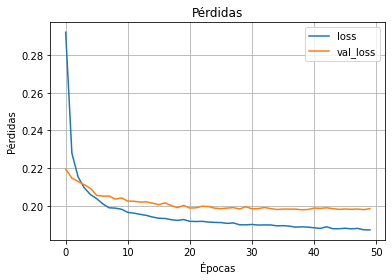

In [ ]:
### Datos de Spotify con Dropout
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
ax = history_df.loc[:, ['loss', 'val_loss']].plot(xlabel='Épocas',title="Pérdidas",grid=True)
ax.set(xlabel='Épocas', ylabel='Pérdidas')
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Recuerde que este modelo tendía a sobreajustar los datos alrededor de la época 5. 

## Normalización por batches

A continuación implementamos la normalización por lotes (batches) para solucionar problemas en el proceso de optimización. En la celda siguiente se carga la base de datos `Concrete`. Esta vez no haremos ninguna normalización previa en los datos. Esto hará que el efecto de la normalización por lotes sea más evidente.

In [ ]:
concrete = pd.read_csv('data_m3/datasets/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(X_train.shape))

Input shape: (721, 8)


Ejecute la siguiente celda para entrenar la red con los datos `Concrete` sin normalizar.

Minimum Validation Loss: nan


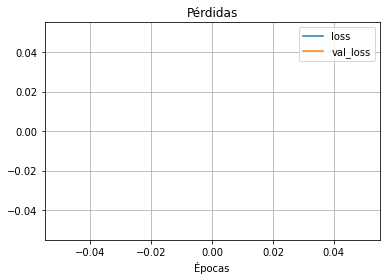

In [ ]:
## Entrenamiento sin batchnorm

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(xlabel='Épocas',title="Pérdidas",grid=True)
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

La normalización por lotes suele ayudar a corregir problemas como éste. Agregue cuatro capas de **batchnorm**, una antes de cada una de las capas densas. En este caso, deberá poner el argumento `input_shape` en la nueva primera capa.

In [ ]:
# EJERCICIO 2 --------- TO DO
# Añada la normalización por batches antes de cada capa densa
model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),

    layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),    

    layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        
    layers.Dense(1),
])

Ejecuta la siguiente celda para ver si la normalización por lotes nos permite entrenar el modelo.

Minimum Validation Loss: 3.9030


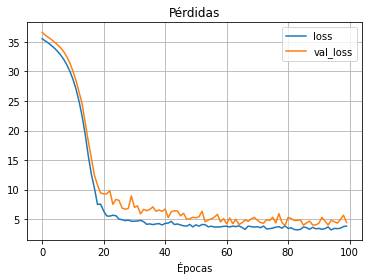

In [ ]:
## Entrenamiento con batchnorm
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(xlabel='Épocas',title="Pérdidas",grid=True)
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

# Clasificación binaria

En esta sección vamos a construir un modelo que permite predecir las cancelaciones en reservas de hoteles mediante un clasificador binario. En primer lugar, cargue el conjunto de datos *hotel*.

In [ ]:
hotel = pd.read_csv('data_m3/datasets/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(X_train.shape))

Input shape: (89542, 63)


## Modelo y entrenamiento

El modelo que usaremos esta vez tendrá capas de **batchnorm** y **dropout**. Para facilitar la visualización del esquema de cálculo de la red neuronal se suele utilizar un diagrama de bloques. Defina un modelo de red neuronal con una arquitectura dada por el siguiente diagrama:

<figure style="padding: 1em;">
<center><img src="https://i.imgur.com/V04o59Z.png" width="400" alt="Diagrama de arquitectura de red: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense."></center>
<figcaption style="textalign: center; font-style: italic"><center>Diagrama de un clasificador binario.</center></figcaption>
</figura>

In [ ]:
# EJERCICIO 3 --------- TO DO
# Defina el modelo del diagrama anterior (CLASIFICADOR BINARIO)
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),

    layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),    
      layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),    
      layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid'),
])

Ahora compile el modelo con el optimizador `Adam` y las versiones binarias de las pérdidas de **entropía cruzada** y la métrica de **precisión**.

In [ ]:
# EJERCICIO 4 --------- TO DO
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Finalmente, ejecute esta celda para entrenar el modelo y ver las curvas de aprendizaje. Puede ejecutarse durante unas 60 o 70 épocas, lo que puede llevar uno o dos minutos.

In [ ]:
### Entrenamiento de un clasificador binario

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0,
)

Best Validation Loss: 0.3480
Best Validation Accuracy: 0.8414


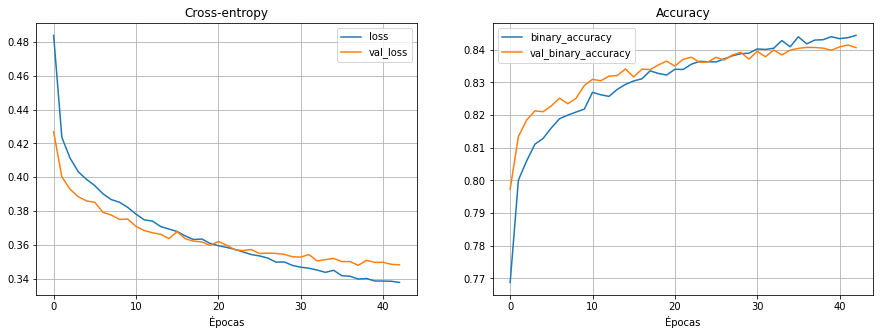

In [ ]:
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
history_df.loc[:, ['loss', 'val_loss']].plot(xlabel='Épocas',ax=ax1,title="Cross-entropy",grid=True)
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(xlabel='Épocas',ax=ax2,title="Accuracy",grid=True)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

Observe la precisión obtenida en la clasificación. Parece bastante rentable tener un buen sistema de análisis de datos, no le parece?!!

# Preguntas

**La adquisición de las competencias asociadas a las prácticas requieren una explicación propia y rigurosa. Las copias y traducciones literales no demuestran la adquisición de las competencias, por tanto no se considerarán válidas (consultar la rúbrica).**

<div class="alert alert-success">

1. ¿Qué es el Dropout? ¿Cuál es su objetivo? ¿Cómo se implementa en Keras? 
</div>

%%%% TO DO %%%%%

Dropout es un tipo de capa que no añade neuronas a nuestra red, sino que agrega una funcionalidad a la red durante el entrenamiendo.
En el caso particular de Dropout, esta funcionalidad radica en suprimir de forma aleatoria un porcentaje de las neuronas de la capa deseada con cada iteración del aprendizaje.

De esta forma, al seleccionarse de forma aleatoria las neoronas suprimidas, podemos evitar los efectos perniciosos del ruido. Este motivo hace de las capas Dropout una herramiena muy buena de corrección del sobreajuste, ya que obliga a nuestro modelo a generalizar, en lugar de aprender patrones de ruido.

Para implementar en keras una capa Dropout, simplemente debemos declarar la siguiente sentendia inmediatemente despues de la capa a la que queremos aplicar la funcionalidad Dropout.

`layers.Dropout( fraccion_a_eliminar )`

Donde "fraccion_a_eliminar" hace referencia al porcentaje de neuronas que queremos suprimir de forma aleatoria.



<div class="alert alert-success">
2. A la vista de los resultados de la celda "### Datos de Spotify con Dropout" y comparándolos con la situación sin Dropout. ¿En qué sentido mejora el Dropout el entrenamiento?
</div>

%%%% TO DO %%%%%

Si estudiabamos el rendimiento del modelo sin agregar capas Dropout, lo que teníamos era un resultado con un claro sobreajuste. Esto se puede ver claramente si nos fijamos en la separación entre la curva de pérdidas obtenidas respecto a la curva de pérdidas teóricas.

<img src="https://drive.google.com/uc?id=1tM5CqnT0aMk340DZIaYllTgcLPhruFsq" width=500 alt="">

El motivo de este sobreajuste era precisamente la existencia de ruido durante el entrenamiento. El cual dominó el aprendizaje impidiendo que el modelo supuese generalizar.

Precisamente las capas Dropout buscan mitigar el ruido en el entrenamiento, y por tanto, impedir que el modelo aprenda a partir de él. Es decir, evita tener una situación de sobreajuste.

Es por esto que al haber vuelto a entrenar el modelo tras añadirle las capas Dropout, tenemos un resultado en el cual el sobreajuste se ha reducido bastante. Tal y como se puede ver si comparamos el resultado siguiente con la imagen anterior.

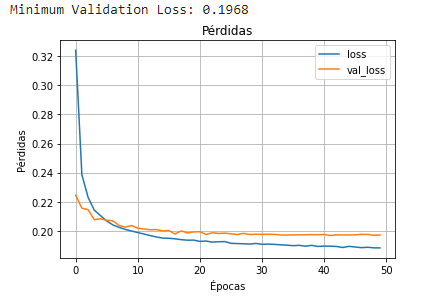


<div class="alert alert-success">

3. ¿Qué es la normalización por lotes (batchnorm)? ¿Cómo se implementa en Keras? 
</div>

%%%% TO DO %%%%%


La normalización en lotes es un proceso que consiste en añadir un paso extra en el uso de los datos por parte del modelo, con la idea de normalizar las activaciones de salida. 

Esta normalización nos permite manejar siempre datos que tengan valores razonablemente cómodos para su manipulación durante el su paso por la neurona. En caso de que no empleemos una normalización en los datos, corremos el riesgo de sufrir desbordamiento por culpa de trabajar con datos complejos.

En concreto, la normalización por lotes trabaja normalizando la salida de cada red de forma independiente. Lo que significa que, si empleamos el SGD para el entrenamiento, en cada iteración se emplearan la media y la varianza de cada salida de la red tras haber trabajado con los datos.


De forma adicional, se suele emplear también esta herramienta para eliminar el sobreajuste producido fruto de la existencia de ruido. Ya que ayuda a mitigat los efectos del ruido en el entrenamiento.

<div class="alert alert-success">

4. Comente los resultados de la celda "## Entrenamiento sin batchnorm". ¿Qué cree que ha ocurrido?
</div>

%%%% TO DO %%%%%

En esta celda, estamos entrenando un modelo formado por 3 capas ocultas densas de 512 neuronas, y una capa densa de salida formada por una sola neurona. El problema de este tipo de redes donde tenemos un entrelazado tan denso y en el cual los datos no son normalizados, es que corremos el riesgo de sufrir un desbordamiento durante el proceso de entrenamiento.

Esto es precisamente lo que nos ha ocurrido, al no establecer ninguna herramienta capaz de prevenir el overflow, el modelo ha ido entrenandose modificando los pesos llegando al punto en que no ha sido capaz de trabajar con los valores obtenidos

. Una pista interesante que nos indica el hecho de haber sufrido overflow, es que aparte de no tener ningún valor que representar, nos ha fijado el valor mínimo como NaN (not a number). Es decir, no sabemos que ha ocurrido, pero estamos seguros que en algún punto dentro de la red hemos sufrido desbordamiento y ha sido imposible seguir trabajando.

<div class="alert alert-success">

5. Comparando los resultados de la celda "## Entrenamiento con `batchnorm`?" con los de la celda "## Entrenamiento sin `batchnorm`". ¿En qué sentido mejora el `batchnorm` el entrenamiento?
</div>


%%%% TO DO %%%%%

En este caso, hemos establecido normalizaciones en cada una de las capas, haciendo que los datos de salida se normalizen de forma independiente.

Esto en efecto nos ha servido para evitar el desbordamiento, y lograr finalizar el entrenamiento. Además de presentar un resultado satisfactorio con un tiempo de computo menor que si no hubiesemos normalizado.

De forma adicional, podemos comprobar que apenas hay sobreajuste. Esto se debe a que esta herramienta también es usada precisamente para la reducción del sobreajuste, por lo que no es de extrañar que el modelo se haya entrenado correctamente.



<div class="alert alert-success">

6. Como se ha comentado, la métrica que mide la `precisión` de la red es el objetivo en la clasificación. ¿Por qué no se usa como función de pérdidas en el entrenamiento? ¿Por que se visualizan las dos en paralelo?
</div>


%%%% TO DO %%%%%

La precisión nos está midiendo el número de predicciones correctas frente al número total de predicciones. Al ser un valor obenido como una proporción sacada a partir de los sucesos, un cambio en uno solo de ellos nos va a probocar un salto brusco.

Precisamente esta variación brusca choca frontalmente con el requisito que nos permite usar el SGD. Ya que SGD requiera que la función presente una variación suabe. Por lo que se requiere de otra función de pérdidas especializada para este tipo de situaciones binarias. Como es el caso de la entropia cruzada.

El hecho de que se representen las dos en paralelo se hace gracias utilizar el subplot. 
Es interesante tener cómodamente estas dos gráficas para poder estudiar los resultados del modelo. Ya que en base a ellas podemos evaluar si el entrenamiento es satisfactorio o no.



<div class="alert alert-success">

7. A la vista de los resultados de la celda "### Entrenamiento de un clasificador binario".
¿Qué conclusiones saca de las curvas de aprendizaje? ¿Tiene el modelo un problema de **overfitting**, o bien de **underfitting**? ¿La función de pérdidas de **entropía cruzada** es un buen indicador de la **precisión**?
</div>

%%%% TO DO %%%%% 

La curva de la izquierda nos permite estudiar si tenenemos sobreajuste o infraajuste. De hecho, hasta aproximadamente la epoca 20 el modelo tenia un infraajuste, y a partir de esa época pasa a un sobreajuste.

La curva de la derecha nos permite estudiar la precisión de nuestro decisor binario. En este caso particular tenemos una precisión final del 84.14%, lo que nos indica que podremos predecir correctamente la mayoría de veces.

Esta curva se ha podido obtener a partir de la entropia cruzada. Por lo que este ejemplo demuestra que es una herramienta capas de afinar bastante la precisión fijandonos en el resultado obtenido.






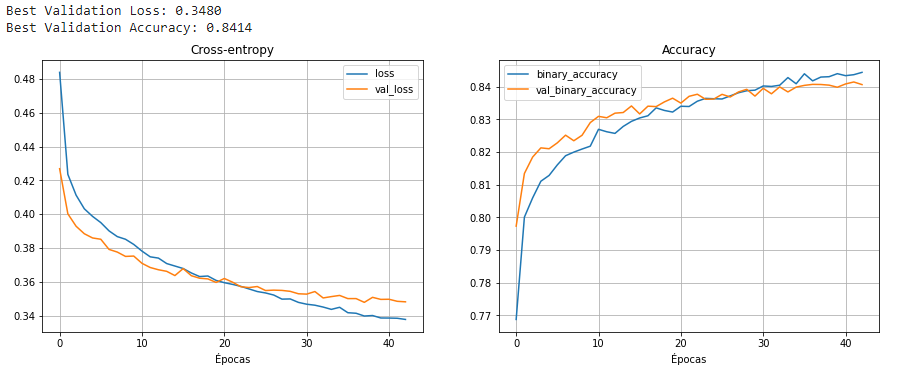

<div class="alert alert-danger">
Pregunta avanzada:

    En el caso de la clasificación, el resultado de la última capa se interpreta como un valor de probabilidad. ¿Cómo pasamos de un valor de probabilidad a realizar una predicción? ¿Por qué es necesario una función de activación sigmoide? Investigue la definición de la entropía cruzada y explique su funcionamiento
</div>

%%%% TO DO %%%%% 

**¿Cómo pasamos de un valor de probabilidad a realizar una predicción?**

Si bien es cierto que los clasificadores binarios nos acaban devolviendo una probabilidad. Esta probabilidad lo que mide es la certeza de que la predicción debuelta por la red sea correcta.

Es decir, la red está aprendiendo a dar mayor o menor importancia a ciertos parámetros que le pasamos a la entrada, de forma con todos ellos pueda caracterizar un comportamiento. Dicha caracterización le permite obtener una probabilidad que mide la certeza de que ocurra o no la predicción, por lo que tecnicamente estamos calculado una predicción respaldada por una probabilidad que mide la certeza de que sea correcta.




**¿Por qué es necesario una función de activación sigmoide?**

Al trabajar con un clasificador binario, los resultados de la red no pueden adquirir un valor cualquiera, sino que deben tomar valores normalizados en el intervalo [0,1]. Donde "1" implica que la predicción que haga la red no tendrá errores, y "0" lo opuesto.

Por este motivo, debemos emplear algo que nos permita "traducir" los valores devueltos por la red en un equivalente perteneciente a este intervalo.
Dicho esto, parece bastante intuitibo que lo que andamos buscando es una función de activación que realize esta tarea.

En este punto es donde se introduce la función sigmoide. La cual permite relacionar cualquier valor numérico con uno perteneciente al intervalo [0,1]. Por lo que la función Sigmoide es necesario siempre y cuando deseemos tener resultados acotados entre 0 y 1.

**Investigue la definición de la entropía cruzada y explique su funcionamiento**

Para comprender la entropia cruzada, debemos tener claro lo que ocurria en un problema
de Regresión Lineal. En estos problemas el entrenamiento consistía en obtener automáticamente los
 parámetros del modelo que permitiesen obtener salidas correctas minizando las pérdidas todo lo posible. Esta optimización de las pérdidas se hacía a partir del uso del algoritmo del Gradiente Descendente.

 En el caso de clasificacion binaria, el paradigma del problema ha cambiado. De entrada, no podemos utilizar el método del gradiente descendente porque su uso está limitado a variaciones suabes de la función. Cosa que no se da en una categorización binaria por el hecho de que la probabilidad de acierto depende de todas las predicciones anteriores, por lo que un cambio proboca una variación brusca.

 Es por esto que debemos emplear otra herramienta capaz de minimizar nuestro error. Y esta herramienta no es otra que la entropia cruzada.

 La entropía cruzada posee dos características muy positibas para enfretarse al proceso de entrenamiento: 


  > 1)Proporciona un minimo único. Cosa que resulta ideal para pasarlo por  el método del gradiente descendente (ya que solo admite un solo minimo)

  > 2) Si la prediccion se aleja del valor real, la pérdida resultante es muy alta. Esto implica que la entropia cruzada penaliza significativamente el hecho de cometer errores. Lo cual mejora al mismo tiempo el proceso de entrenamiento.

  Es decir, la entropía cruzada nos permite seguir minizando las pérdidas y obtener resultados de entrenamiento satisfactorio pese a que los problemas de clasificación binaria no tengan las mísmas caracteristicas que los de regresión lineal.

  Para entender el como funciona, debemos tener en cuenta de donde sale la entroìa cruzada. Y es que esta herramienta la cogemos prestada de la teoría de la comunicación.

  La idea es poder calcular la precisión que tenemos a la hora de predecir procesos probabilisticos. Pese a que la matemática es un poco engorrosa, la base de la entropia cruzada reside en estudiar la probabilidad de que un suceso pasado ocurriese de esa forma. De este modo se pretende utilizar un historico de sucesos para calcular la probabilidad de que un nuevo suceso acotado en las mismas caracteristicas se desarrolle de una u otra manera.

  Este método internamente emplea logaritmos para romper con los problemas relacionados con la estadistica bayestiana. Ya que las probabilidades tratadas son muy pequeñas, y solemos acabar teniendo un problema conocido como  subdesbordamiento aritmético.

Formula de la entropia cruzada:

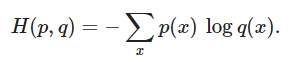

Donde"p" y "q" son probabilidades, y X es el conjunto total de valores sobre los que estudiamos la entropia cruzada.




